### Import Packages

In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Pfade definieren

In [3]:
#Aktueller Pfad (current path)
#cur_path = os.getcwd()
cur_path = "/content/drive/MyDrive/Abschlussarbeiten"
pics_path=os.path.join(cur_path,"Bildervorbearbeitung","Bilder","Auswertung","Zugeschnittene_Bilder")
xlsx_data_path=os.path.join(cur_path,"Bildervorbearbeitung","Bilder","Auswertung","xlsx")

### Daten einladen
Festlegen  der Klassen: Thereshold-array zeigt 3 verscheidene Abstufungen, innerhalb von 1,5 % engere Klassen, da bis zu 1 % die Probe/das Bauteil noch als i.O gewertet wird. Danach etwas weiterer Abstufungen. Ab 10 % Abstufungen von 10 %, da hier das Bauteil schon sehr porös ist und zusätzlich solche Trainingsdaten im bisherigen Trainingsdatensatz nicht existieren.

enumerate heißt es zählt über das Array nacheinander drüber. 0.01 entspricht der Klasse 1, 0.02 entspricht der Klasse 2 ect.
Start=1 heißt, dass es bei Klasse 1 beginnen soll.

Schließlich wird eine neue Liste abgespeichert

In [4]:
df_path = os.path.join(xlsx_data_path, "Porositaet_Zugeschnittene_Bilde.xlsx")
df_pre = pd.read_excel(df_path)

In [5]:
import numpy as np

theresholds_narrow = np.arange(0.01, 1.5, 0.01)
thereshold_middle = np.arange(1.5,10.5,0.5)
thereshold_wide = np.arange(20,110,10)
theresholds = np.concatenate((theresholds_narrow, thereshold_middle, thereshold_wide))
print(theresholds)
print("Anzahl der Klassen:", len(theresholds))


def get_class(porosity, thresholds):
    for i, threshold in enumerate(thresholds, start=1):
        if porosity <= threshold:
            return i
    return len(thresholds)

df_pre['Klassen'] = df_pre['Porositaet'].apply(lambda x: get_class(x, theresholds))

# Speichern der Ergebnisse in einer neuen Liste
new_xlsx_path = os.path.join(xlsx_data_path, 'Porositaet_Zugeschnittene_Bilder_mit_Klassen.xlsx')
df_pre.to_excel(new_xlsx_path, index=False)


[1.00e-02 2.00e-02 3.00e-02 4.00e-02 5.00e-02 6.00e-02 7.00e-02 8.00e-02
 9.00e-02 1.00e-01 1.10e-01 1.20e-01 1.30e-01 1.40e-01 1.50e-01 1.60e-01
 1.70e-01 1.80e-01 1.90e-01 2.00e-01 2.10e-01 2.20e-01 2.30e-01 2.40e-01
 2.50e-01 2.60e-01 2.70e-01 2.80e-01 2.90e-01 3.00e-01 3.10e-01 3.20e-01
 3.30e-01 3.40e-01 3.50e-01 3.60e-01 3.70e-01 3.80e-01 3.90e-01 4.00e-01
 4.10e-01 4.20e-01 4.30e-01 4.40e-01 4.50e-01 4.60e-01 4.70e-01 4.80e-01
 4.90e-01 5.00e-01 5.10e-01 5.20e-01 5.30e-01 5.40e-01 5.50e-01 5.60e-01
 5.70e-01 5.80e-01 5.90e-01 6.00e-01 6.10e-01 6.20e-01 6.30e-01 6.40e-01
 6.50e-01 6.60e-01 6.70e-01 6.80e-01 6.90e-01 7.00e-01 7.10e-01 7.20e-01
 7.30e-01 7.40e-01 7.50e-01 7.60e-01 7.70e-01 7.80e-01 7.90e-01 8.00e-01
 8.10e-01 8.20e-01 8.30e-01 8.40e-01 8.50e-01 8.60e-01 8.70e-01 8.80e-01
 8.90e-01 9.00e-01 9.10e-01 9.20e-01 9.30e-01 9.40e-01 9.50e-01 9.60e-01
 9.70e-01 9.80e-01 9.90e-01 1.00e+00 1.01e+00 1.02e+00 1.03e+00 1.04e+00
 1.05e+00 1.06e+00 1.07e+00 1.08e+00 1.09e+00 1.10e

In [6]:
df_path = new_xlsx_path
df = pd.read_excel(df_path)
df.head()

,Bildname,Porositaet,Klassen
0,P_006_quad_Winkel_180_crp_x1_y10_Winkel_180.png,0.4324,44
1,P_006_quad_Winkel_180_crp_x1_y10_Winkel_270.png,0.2328,24
2,P_006_quad_Winkel_180_crp_x1_y10_Winkel_360.png,0.0328,4
3,P_006_quad_Winkel_180_crp_x1_y10_Winkel_90.png,0.2328,24
4,P_006_quad_Winkel_180_crp_x1_y11_Winkel_180.png,0.4900,49


#### Umwandeln von Bildern und Werten aus der Liste in ein Array

In [7]:
X = []
y = []

import_data = pd.read_excel(df_path)
for index, row in import_data.iterrows():
    img_name = row['Bildname']
    img_path = os.path.join(pics_path, img_name)
    img = cv2.imread(img_path)
    X.append(img)
    y.append(row['Klassen'])

print("Anzahl der Datenpaare:",len(y))

X = np.array(X)
y = np.array(y)

Anzahl der Datenpaare: 224


#### Train-Test-Split

In [8]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, normalize
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.25)

y_train_cat = to_categorical(y_train, num_classes=176)
y_test_cat = to_categorical(y_test, num_classes=176)
print(y_test_cat)
print(X_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [235 235 235]
   [234 234 234]
   ...
   [236 236 236]
   [234 234 234]
   [235 235 235]]

  [[  0   0   0]
   [238 238 238]
   [236 236 236]
   ...
   [236 236 236]
   [234 234 234]
   [235 235 235]]

  ...

  [[  0   0   0]
   [234 234 234]
   [234 234 234]
   ...
   [237 237 237]
   [238 238 238]
   [238 238 238]]

  [[  0   0   0]
   [233 233 233]
   [233 233 233]
   ...
   [238 238 238]
   [238 238 238]
   [237 237 237]]

  [[  0   0   0]
   [232 232 232]
   [232 232 232]
   ...
   [238 238 238]
   [236 236 236]
   [236 236 236]]]


 [[[  0   0   0]
   [233 233 233]
   [232 232 232]
   ...
   [226 226 226]
   [227 227 227]
   [227 227 227]]

  [[  0   0   0]
   [233 233 233]
   [231 231 231]
   ...


Eingangsdaten Bild: Pixelgröße und Eingangsfarbkanäle (500, 500, 3)
Porosität [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


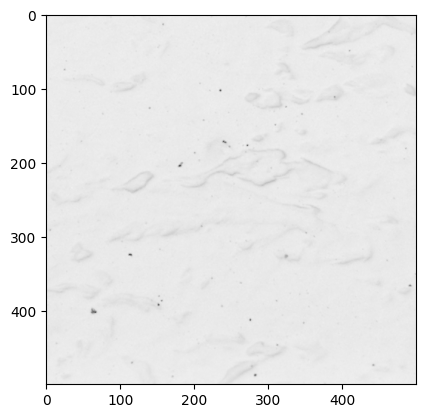

In [9]:
plt.imshow(X_train[100])
plt.show

print("Eingangsdaten Bild: Pixelgröße und Eingangsfarbkanäle", X_train[100].shape)
print("Porosität",y_train_cat[100])

In [28]:
#Test Marius
import random

XS = 350
YS = 350

buffer = cv2.cvtColor(X_train[0], cv2.COLOR_BGR2GRAY)
buffer = cv2.resize(buffer, (XS, YS))
X_train_grey = np.array([buffer])
for i in range (1,168):
    buffer = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2GRAY)
    buffer = cv2.resize(buffer, (XS, YS))
    X_train_grey = np.append(X_train_grey, [buffer], axis=0)



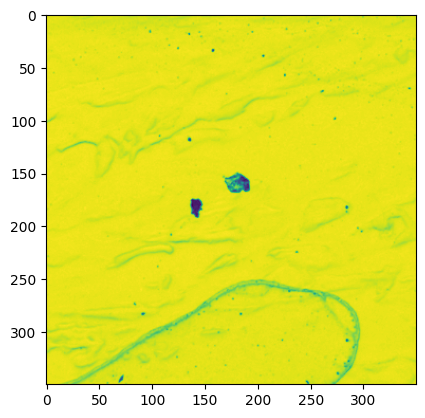

Eingangsdaten Bild (350, 350)


In [29]:
#Test Marius
%matplotlib inline

import matplotlib.pyplot as plt

plt.imshow(X_train_grey[1])
plt.show()

print("Eingangsdaten Bild", X_train_grey[1].shape)


In [30]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

tf.compat.v1.disable_eager_execution()

model = Sequential()

#Convolutional Laqyers
model.add(Conv2D(50, kernel_size=(5, 5), activation="relu", input_shape=(XS, YS, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(100, activation="sigmoid"))
model.add(Dense(50, activation="sigmoid"))
model.add(Dense(176, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

model.fit(
    X_train_grey.reshape(-1, XS, YS, 1),
    y_train_cat,
    epochs=10,
    batch_size=20)

Train on 168 samples
Epoch 1/10
168/168 [==============================] - 2s 12ms/sample - loss: 4.9778 - accuracy: 0.0357
Epoch 2/10
168/168 [==============================] - 2s 12ms/sample - loss: 4.6091 - accuracy: 0.0655
Epoch 3/10
168/168 [==============================] - 2s 12ms/sample - loss: 4.3634 - accuracy: 0.0774
Epoch 4/10
168/168 [==============================] - 2s 12ms/sample - loss: 4.1748 - accuracy: 0.0774
Epoch 5/10
168/168 [==============================] - 2s 12ms/sample - loss: 4.0411 - accuracy: 0.0774
Epoch 6/10
168/168 [==============================] - 2s 12ms/sample - loss: 3.9438 - accuracy: 0.0774
Epoch 7/10
168/168 [==============================] - 2s 12ms/sample - loss: 3.8769 - accuracy: 0.0774
Epoch 8/10
168/168 [==============================] - 2s 12ms/sample - loss: 3.8283 - accuracy: 0.0774
Epoch 9/10
168/168 [==============================] - 2s 12ms/sample - loss: 3.7923 - accuracy: 0.0774
Epoch 10/10
168/168 [==============================]

In [38]:
buffer_1 = cv2.cvtColor(X_test[0], cv2.COLOR_BGR2GRAY)
buffer_1 = cv2.resize(buffer, (XS, YS))
X_test_grey = np.array([buffer_1])
for i in range (1,56):
    buffer_1 = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2GRAY)
    buffer_1 = cv2.resize(buffer_1, (XS, YS))
    X_test_grey = np.append(X_test_grey, [buffer_1], axis=0)



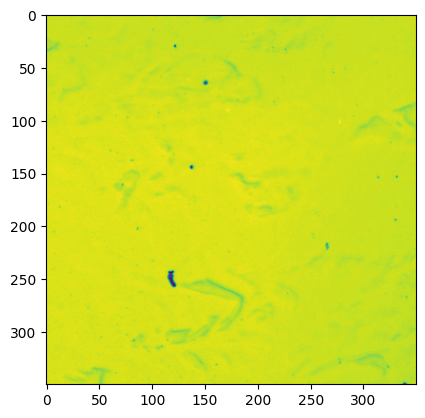

Eingangsdaten Bild (350, 350)


In [39]:
#Test Marius
%matplotlib inline

import matplotlib.pyplot as plt

plt.imshow(X_test_grey[5])
plt.show()

print("Eingangsdaten Bild", X_test_grey[5].shape)

In [41]:
model.evaluate(X_test_grey.reshape(-1, XS, YS, 1), y_test_cat)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


[4.125827312469482, 0.10714286]

### Modell erstellen

In [17]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D, Reshape
from keras.layers import Dense, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.optimizers import SGD, RMSprop
from numpy import reshape

model = Sequential()

# model.add(Lambda(standardize, input_shape=(28, 28, 1)))

# model.add(Reshape((500, 500, 3), input_shape=(None, 500, 500, 3)))

#model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(500, 500, 3)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(500, 500, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(512, activation="relu"))
model.add(Dense(176, activation="softmax"))  # 176 verschiedene Klassen (siehe oben)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 498, 498, 64)      640       
                                                                 
 conv2d_6 (Conv2D)           (None, 496, 496, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 248, 248, 64)      0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 248, 248, 64)      256       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 246, 246, 128)     73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 244, 244, 128)    

In [21]:
#opt = SGD(lr=0.001, momentum=0.9)
opt = "adam"
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [22]:
#Test Marius
model.fit(
    X_train_grey.reshape(-1, 500, 500, 1),
    y_train_cat,
    epochs = 5,
    batch_size = 16

)

ValueError: ignored

#### Modell kompalieren

In [12]:
model.fit(
    X_train,
    y_train_cat,
    epochs = 5,
    batch_size = 32
)

Epoch 1/5


ResourceExhaustedError: ignored